In [1]:
import math
from pathlib import Path
from typing import List
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
# from SURE.custom.Core.Model import BuildModel, TrainModel, GroundTruth, ComputeIOUs  # Importing necessary functions and classes
from Core.Model import BuildModel, TrainModel, GroundTruth, ComputeIOUs

c:\Users\chisa\miniconda3\envs\nomi3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
root_path = Path('.') / 'SURE/datasets/handpicked/3'

In [4]:
training_sets = root_path / 'subsets'
save_directory = root_path / 'models'

(training_sets, save_directory)

(WindowsPath('SURE/datasets/handpicked/3/subsets'),
 WindowsPath('SURE/datasets/handpicked/3/models'))

In [5]:
def get_ground_truths(images_dir: Path, segmentations_dir: Path) -> List[GroundTruth]:
    image_paths = list(images_dir.glob('*.png'))
    segmentation_paths = list(segmentations_dir.glob('*.png'))
    
    ground_truths = []
    for img_path in image_paths:
        seg_path = segmentations_dir / img_path.name
        if seg_path in segmentation_paths:
            ground_truths.append(GroundTruth(img_path, seg_path))
    
    return ground_truths

def retrieve_ground_truths(root_path: Path):
    training_images_dir = root_path / "training" / "images"
    training_segmentations_dir = root_path / "training" / "segmentations"
    validation_images_dir = root_path / "validation" / "images"
    validation_segmentations_dir = root_path / "validation" / "segmentations"
    test_images_dir = root_path / "testing" / "images"
    test_segmentations_dir = root_path / "testing" / "segmentations"

    # Get all ground truths
    all_training_ground_truths = get_ground_truths(training_images_dir, training_segmentations_dir)
    validation_ground_truths = get_ground_truths(validation_images_dir, validation_segmentations_dir)
    test_ground_truths = get_ground_truths(test_images_dir, test_segmentations_dir)
    
    return all_training_ground_truths, validation_ground_truths, test_ground_truths

In [6]:
image_size = (512, 512)  # Adjust if your image size is different
dropout_rate = 0.125
first_layer_filter_count = 8

# Training parameters
learning_rate = 0.001
patience = 10
epochs = 10
batch_size = 8
save_name_prefix = "UNet"
save_lite = False
save_all = True

In [7]:
train_ious = []
val_ious = []
test_ious = []

folder_names = [folder for folder in training_sets.iterdir() if folder.is_dir()]
folder_names.sort(key=lambda x: int(x.name))

alldata = []

In [8]:
load_model = False

In [9]:
from Core.ImageHandling import LoadPILImages
from Core.Model import LoadFullModel


if load_model:
    test_path = Path(r'SURE\datasets\original\MouseOrganoids')
    ground = retrieve_ground_truths(test_path)[2]
    model_path = save_directory / "100/UNet_100_images_E063"
    model = LoadFullModel(model_path)
    iou = ComputeIOUs(model, LoadPILImages([gt.imagePath for gt in ground]), LoadPILImages([gt.segmentationPath for gt in ground]))
    
    print(f"Mean:{np.mean(iou)}; Std: {np.std(iou)}")

In [10]:
for folder in folder_names[:2]:
    print(f"Training with {folder} images")
    
    # Create the model
    model = BuildModel(image_size, dropout_rate, first_layer_filter_count)
    
    training_ground_truths, validation_ground_truths, test_ground_truths = retrieve_ground_truths(folder)
    
    # Train the model
    TrainModel(
        model=model,
        learningRate=learning_rate,
        patience=patience,
        epochs=epochs,
        batchSize=batch_size,
        trainingData=training_ground_truths,
        validationData=validation_ground_truths,
        saveDirectory=save_directory / str(folder.name),
        saveNamePrefix=f"{save_name_prefix}_{folder.name}_images",
        saveLite=save_lite,
        saveAll=save_all
    )
    
    # Compute IoU for training, validation, and test sets
    train_iou = ComputeIOUs(model, LoadPILImages([gt.imagePath for gt in training_ground_truths]), LoadPILImages([gt.segmentationPath for gt in training_ground_truths]))
    train_iou_mean = np.mean(train_iou)
    train_iou_std = np.std(train_iou)
    
    val_iou = ComputeIOUs(model, LoadPILImages([gt.imagePath for gt in validation_ground_truths]), LoadPILImages([gt.segmentationPath for gt in validation_ground_truths]))
    val_iou_mean = np.mean(val_iou)
    val_iou_std = np.std(val_iou)
    
    test_iou = ComputeIOUs(model, LoadPILImages([gt.imagePath for gt in test_ground_truths]), LoadPILImages([gt.segmentationPath for gt in test_ground_truths]))
    test_iou_mean = np.mean(test_iou)
    test_iou_std = np.std(test_iou)
    
    alldata.append({
        "image_count": int(folder.name),
        "train_iou_mean": train_iou_mean,
        "train_iou_std": train_iou_std,
        
        "val_iou_mean": val_iou_mean,
        "val_iou_std": val_iou_std,
        
        "test_iou_mean": test_iou_mean,
        "test_iou_std": test_iou_std
    })
    
    print(f"Training IoU: {train_iou_mean:.4f}")
    print(f"Validation IoU: {val_iou_mean:.4f}")
    print(f"Test IoU: {test_iou_mean:.4f}")
    print(f"Finished training with {folder.name} images\n")

print("Training complete for all image counts")

Training with SURE\datasets\handpicked\3\subsets\20 images
Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 32.6659
Epoch 1: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E001


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E001\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E001\assets


3/3 [==============================] - 25s 3s/step - loss: 32.6659 - val_loss: 6.8066
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 7.9589
Epoch 2: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E002


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E002\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E002\assets


3/3 [==============================] - 4s 2s/step - loss: 7.9589 - val_loss: 6.9858
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 5.9312
Epoch 3: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E003


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E003\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E003\assets


3/3 [==============================] - 4s 2s/step - loss: 5.9312 - val_loss: 4.9964
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 4.2628
Epoch 4: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E004


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E004\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E004\assets


3/3 [==============================] - 4s 2s/step - loss: 4.2628 - val_loss: 3.0646
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 3.1408
Epoch 5: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E005


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E005\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E005\assets


3/3 [==============================] - 4s 2s/step - loss: 3.1408 - val_loss: 2.1543
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 2.4670
Epoch 6: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E006


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E006\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E006\assets


3/3 [==============================] - 4s 2s/step - loss: 2.4670 - val_loss: 1.7203
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 2.0762
Epoch 7: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E007


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E007\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E007\assets


3/3 [==============================] - 4s 2s/step - loss: 2.0762 - val_loss: 1.5544
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 1.8664
Epoch 8: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E008


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E008\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E008\assets


3/3 [==============================] - 4s 2s/step - loss: 1.8664 - val_loss: 1.6467
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 1.7526
Epoch 9: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E009


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E009\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E009\assets


3/3 [==============================] - 4s 2s/step - loss: 1.7526 - val_loss: 1.5994
Epoch 10/10
3/3 [==============================] - ETA: 0s - loss: 1.6309
Epoch 10: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E010


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E010\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\20\UNet_20_images_E010\assets


3/3 [==============================] - 4s 2s/step - loss: 1.6309 - val_loss: 1.2878


INFO:tensorflow:Assets written to: SURE\datasets\handpicked\3\models\20\UNet_20_images_BEST\assets


INFO:tensorflow:Assets written to: SURE\datasets\handpicked\3\models\20\UNet_20_images_BEST\assets


Loading images...0/1/2/3/4/5/6/7/8/9/10/211/212/213/214/215/216/217/218/219/20 
Done
Running model...
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 2s 2s/step
----------------------------------------------------------------------------------------------------
Done.
Loading images...0/1/2/3/4/5 
Done
Running model...
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 25ms/step
----------------------------------------------------------------------------------------------------
Done.
Loading images...0/1/2/3/4 
Done
Running model...
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 23ms/step
----------------------------------------------------------------------------------------------------
Done.
Training IoU: 0.21

INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E001\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E001\assets


5/5 [==============================] - 7s 1s/step - loss: 9.9694 - val_loss: 2.3992
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 2.6310
Epoch 2: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E002


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E002\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E002\assets


5/5 [==============================] - 5s 1s/step - loss: 2.6310 - val_loss: 2.0607
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 1.9312
Epoch 3: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E003


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E003\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E003\assets


5/5 [==============================] - 5s 1s/step - loss: 1.9312 - val_loss: 1.7437
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 1.6506
Epoch 4: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E004


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E004\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E004\assets


5/5 [==============================] - 5s 1s/step - loss: 1.6506 - val_loss: 1.5859
Epoch 5/10
5/5 [==============================] - ETA: 0s - loss: 1.4830
Epoch 5: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E005


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E005\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E005\assets


5/5 [==============================] - 5s 1s/step - loss: 1.4830 - val_loss: 1.4857
Epoch 6/10
5/5 [==============================] - ETA: 0s - loss: 1.3652
Epoch 6: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E006


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E006\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E006\assets


5/5 [==============================] - 5s 1s/step - loss: 1.3652 - val_loss: 1.3525
Epoch 7/10
5/5 [==============================] - ETA: 0s - loss: 1.2507
Epoch 7: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E007


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E007\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E007\assets


5/5 [==============================] - 5s 1s/step - loss: 1.2507 - val_loss: 1.2592
Epoch 8/10
5/5 [==============================] - ETA: 0s - loss: 1.1534
Epoch 8: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E008


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E008\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E008\assets


5/5 [==============================] - 5s 1s/step - loss: 1.1534 - val_loss: 1.1397
Epoch 9/10
5/5 [==============================] - ETA: 0s - loss: 1.0598
Epoch 9: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E009


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E009\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E009\assets


5/5 [==============================] - 5s 1s/step - loss: 1.0598 - val_loss: 1.0898
Epoch 10/10
5/5 [==============================] - ETA: 0s - loss: 0.9845
Epoch 10: saving model to c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E010


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E010\assets


INFO:tensorflow:Assets written to: c:\Users\chisa\Documents\GitHub\OrganoID_IIT\SURE\datasets\handpicked\3\models\40\UNet_40_images_E010\assets


5/5 [==============================] - 5s 1s/step - loss: 0.9845 - val_loss: 1.0069


INFO:tensorflow:Assets written to: SURE\datasets\handpicked\3\models\40\UNet_40_images_BEST\assets


INFO:tensorflow:Assets written to: SURE\datasets\handpicked\3\models\40\UNet_40_images_BEST\assets


Loading images...0/1/2/3/4/5/6/7/8/9/10/411/412/413/414/415/416/417/418/419/420/421/422/423/424/425/426/427/428/429/430/431/432/433/434/435/436/437/438/439/40 
Done
Running model...
----------------------------------------------------------------------------------------------------
2/2 [==============================] - 2s 89ms/step
----------------------------------------------------------------------------------------------------
Done.
Loading images...0/1/2/3/4/5/6/7/8/9 
Done
Running model...
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 1s 596ms/step
----------------------------------------------------------------------------------------------------
Done.
Loading images...0/1/2/3/4/5/6/7/8/9 
Done
Running model...
----------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 24ms/step
------------------------

In [11]:
df = pd.DataFrame(alldata)
df

,image_count,train_iou_mean,train_iou_std,val_iou_mean,val_iou_std,test_iou_mean,test_iou_std
0,20,0.218386,0.076906,0.266032,0.038506,0.175782,0.032881
1,40,0.312983,0.103932,0.300608,0.106498,0.292122,0.095971


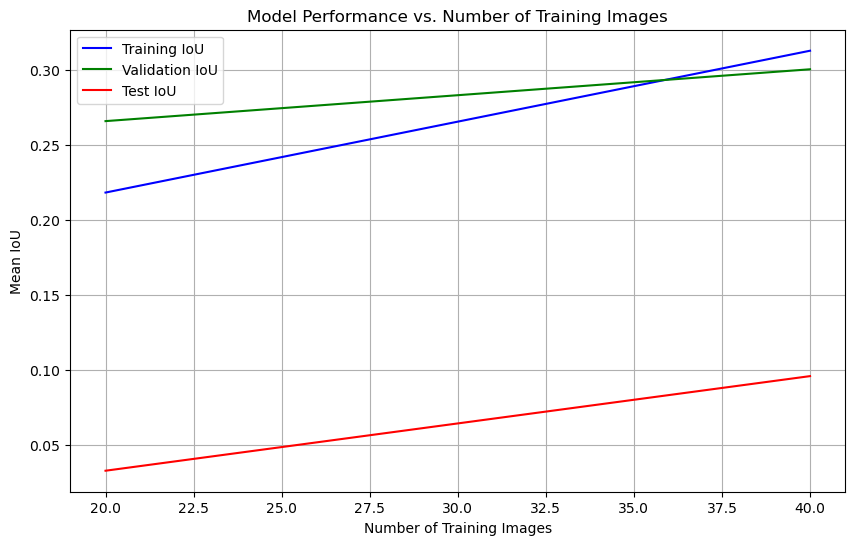

In [12]:
df = pd.DataFrame(alldata)
df.to_csv("iou_data.csv")
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(df["image_count"], df["train_iou_mean"], 'b-', label='Training IoU')
plt.plot(df["image_count"], df["val_iou_mean"], 'g-', label='Validation IoU')
plt.plot(df["image_count"], df["test_iou_std"], 'r-', label='Test IoU')
plt.xlabel('Number of Training Images')
plt.ylabel('Mean IoU')
plt.title('Model Performance vs. Number of Training Images')
plt.legend()
plt.grid(True)
plt.savefig('iou_vs_training_images.png')
plt.show()